# Distributional assumption test

In [1154]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [1155]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [193]:
import warnings
#warnings.warn('ignore')

In [194]:
%matplotlib inline

In [195]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [196]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/'

### Simulate the data

In [1133]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [1134]:
N = 50000

In [1135]:
# Simluate the noise
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)
qs = stats.beta.rvs(alpha, beta, size=N)

In [1153]:
v

0.0020497555225805018

In [1136]:
# Set true parameters
poi_lambda = 2
norm_mean = 8
norm_var = 3
lognorm_mean = 2
lognorm_var = 0.3
nb_mean = 5
nb_theta = 2

In [1137]:
# Generate the true distributions
poi = stats.poisson.rvs(poi_lambda, size=N)
norm = np.maximum(stats.norm.rvs(loc=norm_mean, scale=np.sqrt(norm_var), size=N).astype(int), 0)
lognorm = np.exp(stats.norm.rvs(loc=lognorm_mean, scale=np.sqrt(lognorm_var), size=N)).astype(int)
nb = stats.nbinom.rvs(*convert_params(nb_mean,nb_theta), size=N)

In [1138]:
# Apply the noise process
poi_obs = stats.binom.rvs(n=poi, p=qs)
norm_obs = stats.binom.rvs(n=norm, p=qs)
lognorm_obs = stats.binom.rvs(n=lognorm, p=qs)
nb_obs = stats.binom.rvs(n=nb, p=qs)

In [1139]:
# Create an ann data out of these
obs_df = pd.DataFrame()
obs_df['n_counts'] = [1e10 for i in range(N)]
obs_df['cell_type'] = 'A'
values = np.vstack([poi_obs, norm_obs, lognorm_obs, nb_obs]).T
adata = sc.AnnData(
    values, 
    var=pd.DataFrame(index=['Poi Gene', 'Norm Gene', 'Lognorm Gene', 'NB Gene']),
    obs=obs_df)

Transforming to str index.


### Create an estimator and fit the simulated data

In [1140]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)
estimator.beta_sq = p_sq

In [1141]:
estimator.compute_observed_moments('A')
estimator.compute_observed_moments('-A')

In [1142]:
estimator.estimate_parameters()

In [1143]:
estimator.estimated_central_moments['A']['second'][1]

3.349983718142866

In [1144]:
norm_var

3

### Get the parameters to reconstruct the distributions

In [1145]:
est_poi_lambda = estimator.estimated_central_moments['A']['first'][0]# + estimator.estimated_central_moments['A']['second'][0])/2
est_norm_mean = estimator.estimated_central_moments['A']['first'][1]
est_norm_var = estimator.estimated_central_moments['A']['second'][1]
temp = 1 + estimator.estimated_central_moments['A']['second'][2]/estimator.estimated_central_moments['A']['first'][2]**2
est_lognorm_var = np.log(temp)
est_lognorm_mean = np.log(
    estimator.estimated_central_moments['A']['first'][2]) - np.log(np.sqrt(temp))
est_nb_mean = estimator.estimated_central_moments['A']['first'][3]
est_nb_theta = \
    1/((estimator.estimated_central_moments['A']['second'][3] - \
    estimator.estimated_central_moments['A']['first'][3])/ \
    estimator.estimated_central_moments['A']['first'][3]**2)

### Plot the simulation results

In [1169]:
def plot_distributions(x, true_pmf, est_poi_pmf, obs, title):
    
    fig, ax1 = plt.subplots()

    color = 'tab:brown'
    ax1.set_xlabel('mRNA content')
    ax1.set_ylabel('Observed probability', color=color)
    ax1.hist(obs, color=color, bins=np.bincount(obs).shape[0], density=True)
    ax1.set_title(title)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Latent probability')
    ax2.plot(x, est_poi_pmf, 
             marker='o' if title == 'Negative Binomial' or title == 'Poisson' else None,
             mfc='none', 
             ms=20, 
             linestyle='--', 
             mew=4, 
             linewidth=0 if title == 'Poisson' or title == 'Negative Binomial' else 7, 
             label='Estimated')
    ax2.plot(x, true_pmf, 
             marker='x' if title == 'Negative Binomial' or title == 'Poisson' else None, 
             mfc='none',
             ms=7, 
             linestyle='--', 
             mew=4, 
             linewidth=0 if title == 'Poisson' or title == 'Negative Binomial' else 7, 
             label='Ground truth')
    ax2.legend(labelspacing=1.3, borderpad=0.9)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

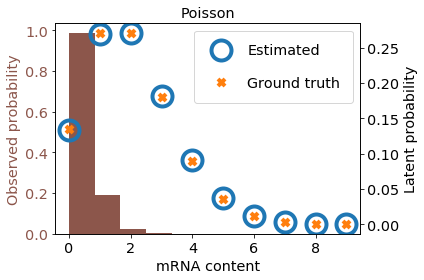

In [1170]:
x = np.arange(0, 10, 1)

plot_distributions(
    x, 
    stats.poisson.pmf(x, poi_lambda), 
    stats.poisson.pmf(x, est_poi_lambda), 
    poi_obs, 'Poisson')
plt.savefig(data_path + '../figures/simulation/poisson.pdf')
plt.savefig(data_path + '../figures/simulation/poisson.png')

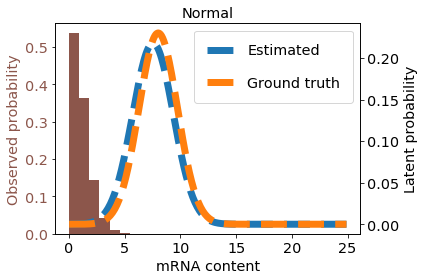

In [1171]:
x = np.arange(0, 25, 0.1)

plot_distributions(
    x, 
    stats.norm.pdf(x, norm_mean, np.sqrt(norm_var)), 
    stats.norm.pdf(x, est_norm_mean, np.sqrt(est_norm_var)), 
    norm_obs, 'Normal')
plt.savefig(data_path + '../figures/simulation/norm.pdf')
plt.savefig(data_path + '../figures/simulation/norm.png')

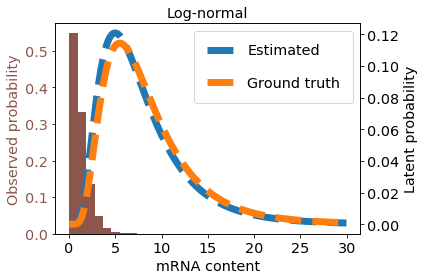

In [1172]:
x = np.arange(0, 30, 0.01)

plot_distributions(
    x, 
    stats.lognorm.pdf(x, scale=np.exp(lognorm_mean), s=np.sqrt(lognorm_var)), 
    stats.lognorm.pdf(x, scale=np.exp(est_lognorm_mean), s=np.sqrt(est_lognorm_var)), 
    lognorm_obs, 'Log-normal')
plt.savefig(data_path + '../figures/simulation/lognorm.pdf')
plt.savefig(data_path + '../figures/simulation/lognorm.png')

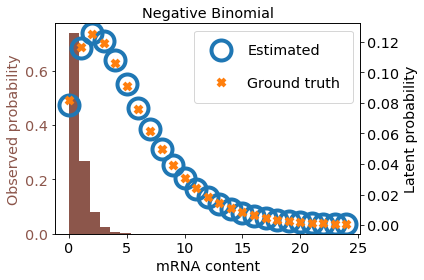

In [1173]:
x = np.arange(0, 25, 1)

plot_distributions(
    x, 
    stats.nbinom.pmf(x, *convert_params(nb_mean,nb_theta)), 
    stats.nbinom.pmf(x, *convert_params(est_nb_mean,est_nb_theta)), 
    nb_obs, 'Negative Binomial')
plt.savefig(data_path + '../figures/simulation/negbin.pdf')
plt.savefig(data_path + '../figures/simulation/negbin.png')